# Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score

In [2]:
train_features = pd.read_csv('hackathon/training_set_features.csv')
train_labels = pd.read_csv('hackathon/training_set_labels.csv')
test_features = pd.read_csv('hackathon/test_set_features.csv')
submission_format = pd.read_csv('hackathon/submission_format.csv')

In [3]:
# Merge the training features and labels
train_data = train_features.merge(train_labels, on='respondent_id')

In [4]:
train_data['age_group'].value_counts()

age_group
65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: count, dtype: int64

In [5]:
train_data.shape

(26707, 38)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   xyz_concern                  26615 non-null  float64
 2   xyz_knowledge                26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_xyz              24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
# Check for missing values
train_data.isnull().sum()
# print(missing_values[missing_values > 0])

respondent_id                      0
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

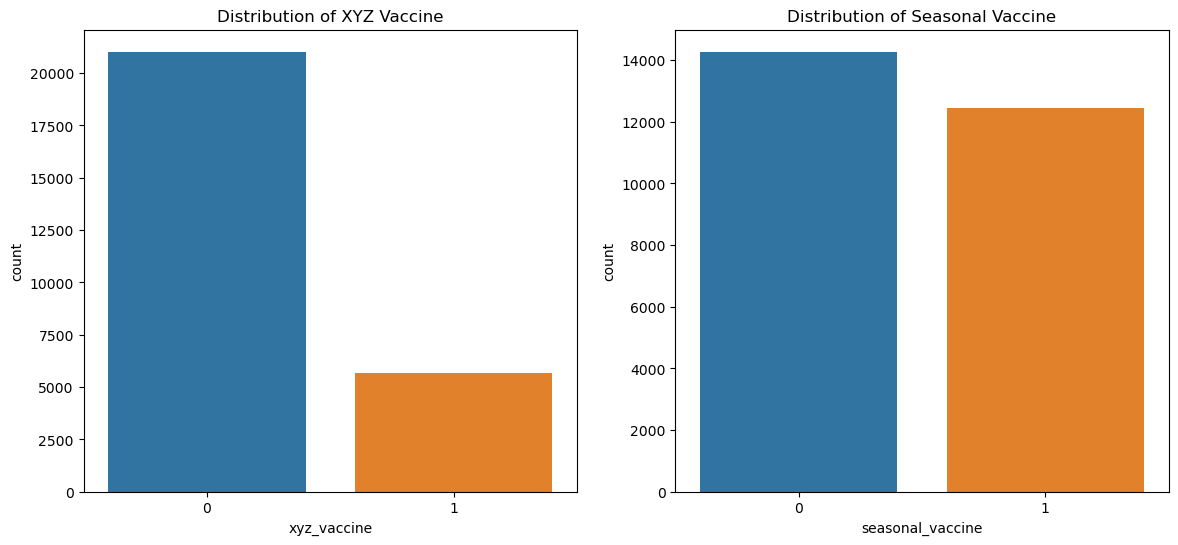

In [8]:
# Distribution of target variables
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x='xyz_vaccine', data=train_data, ax=ax[0])
ax[0].set_title('Distribution of XYZ Vaccine')
sns.countplot(x='seasonal_vaccine', data=train_data, ax=ax[1])
ax[1].set_title('Distribution of Seasonal Vaccine')
plt.show()

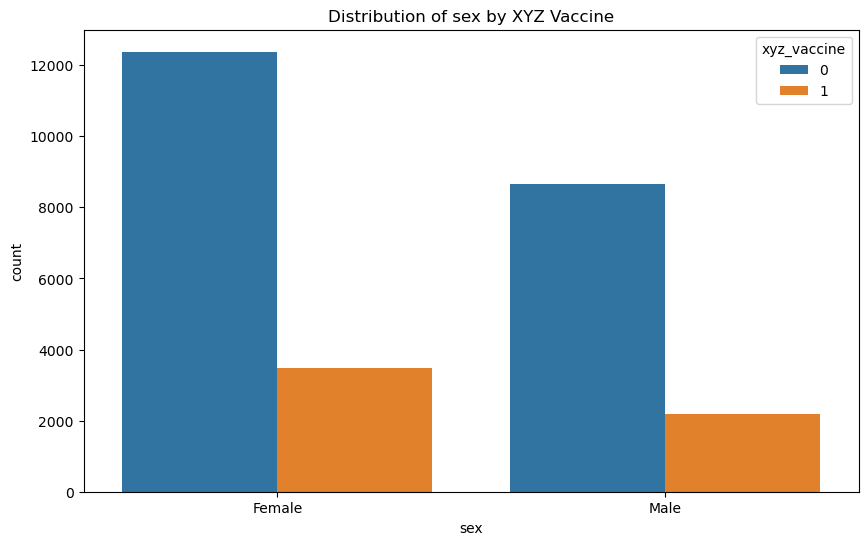

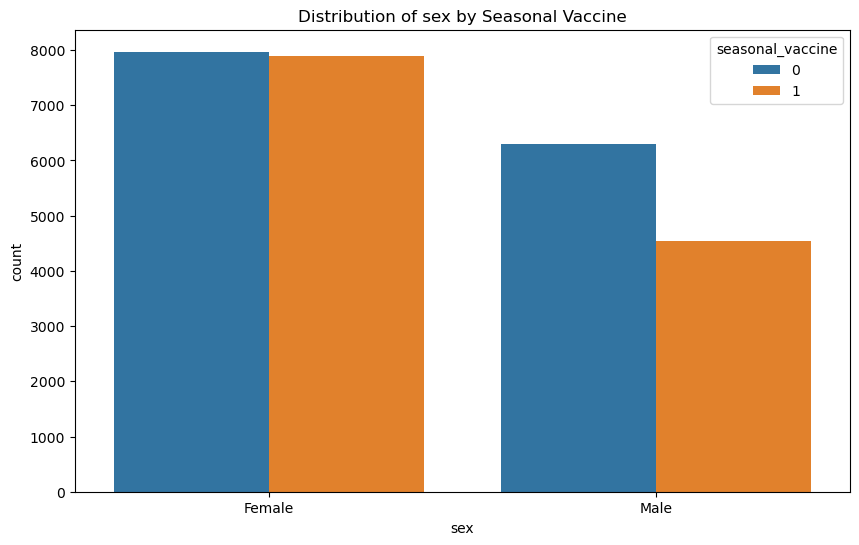

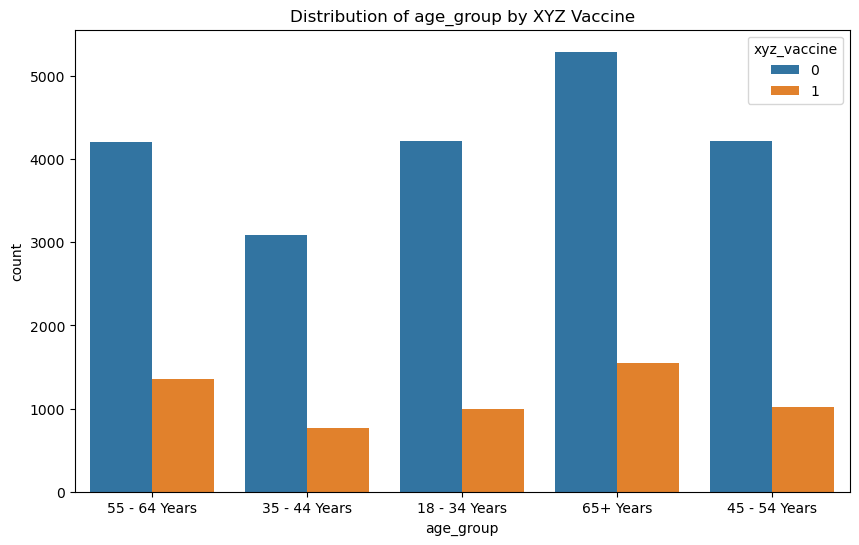

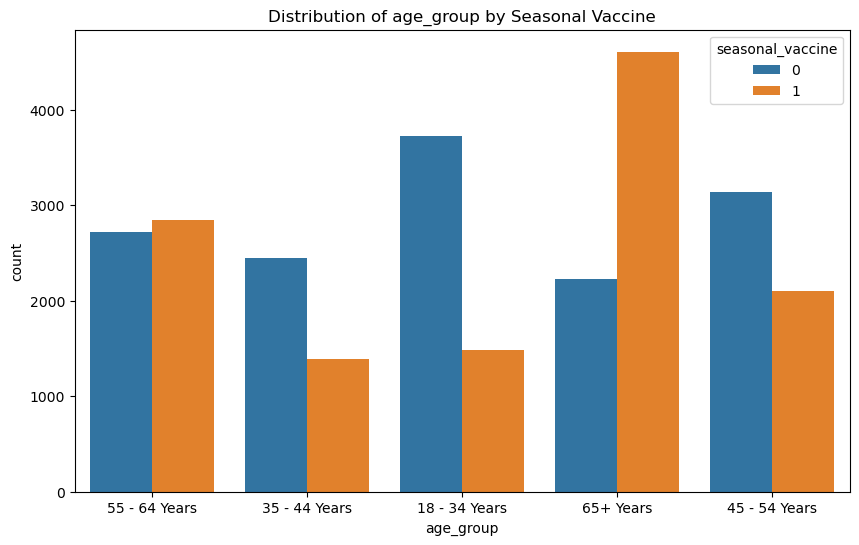

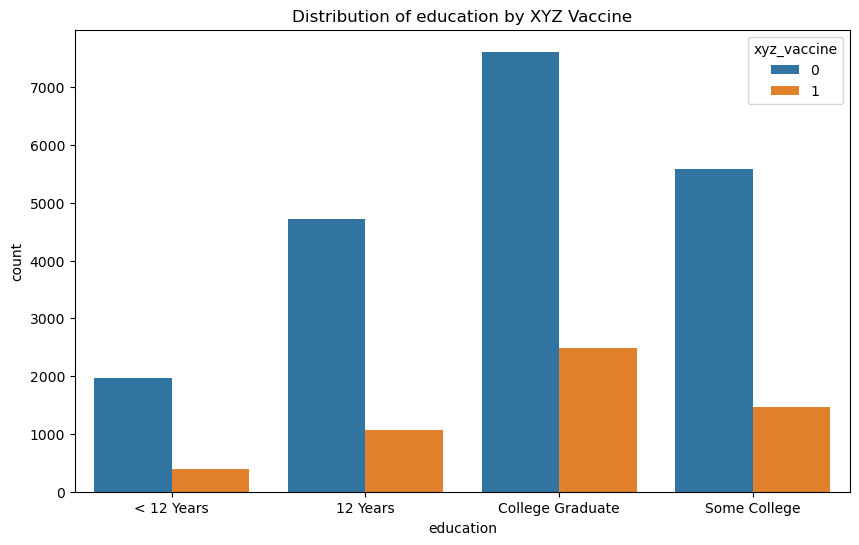

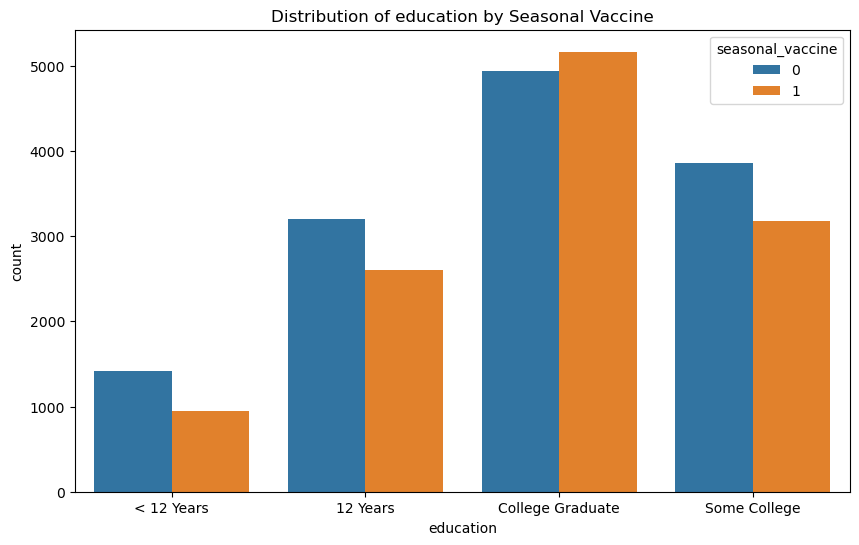

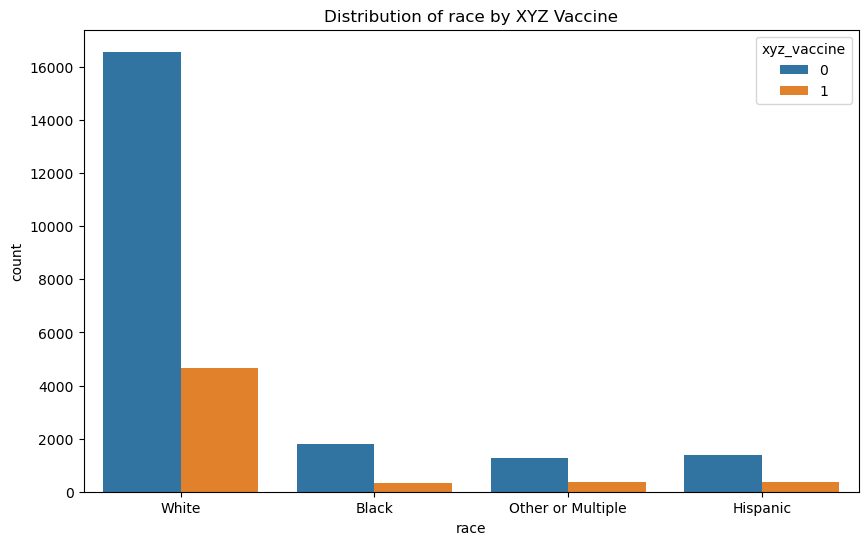

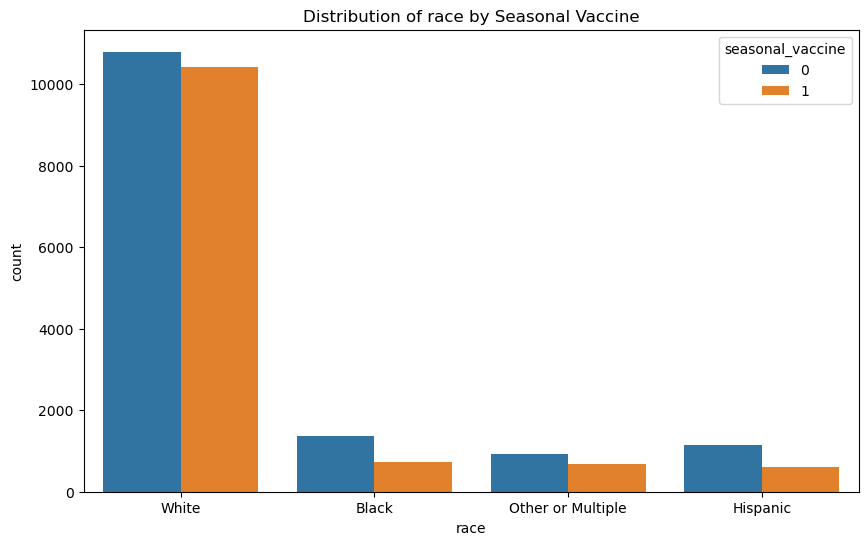

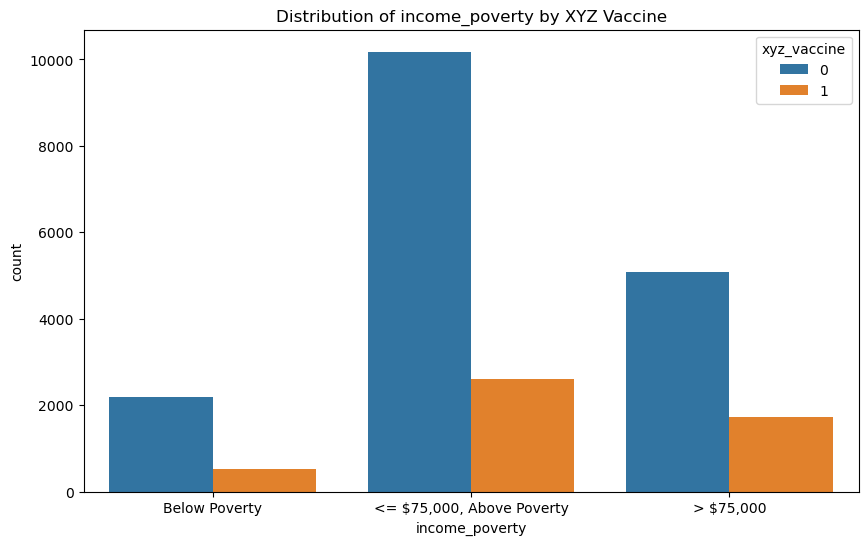

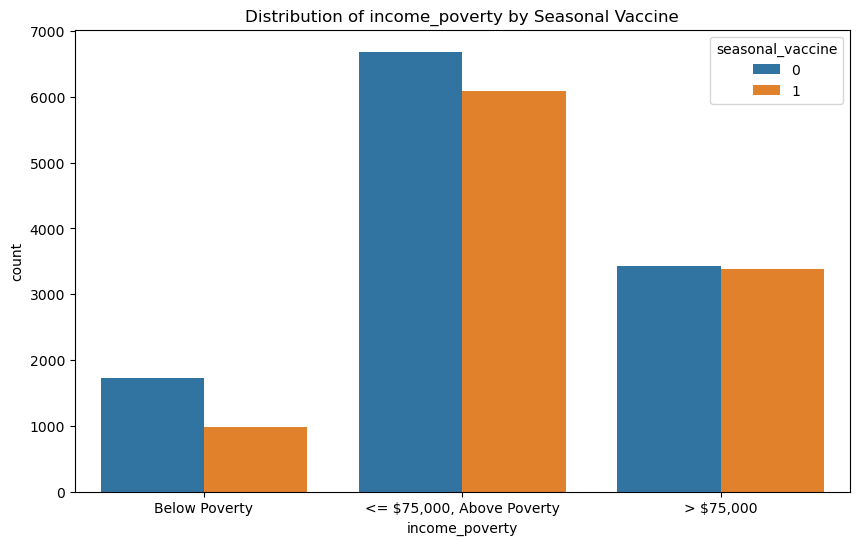

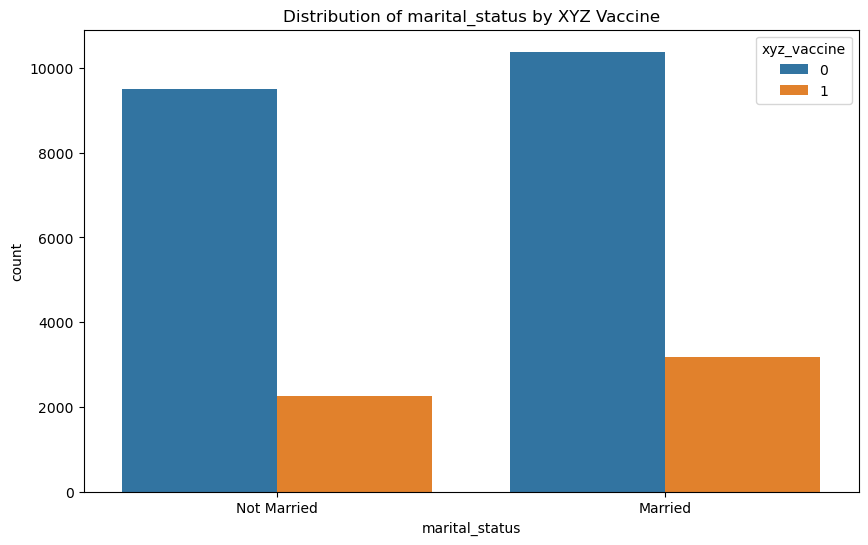

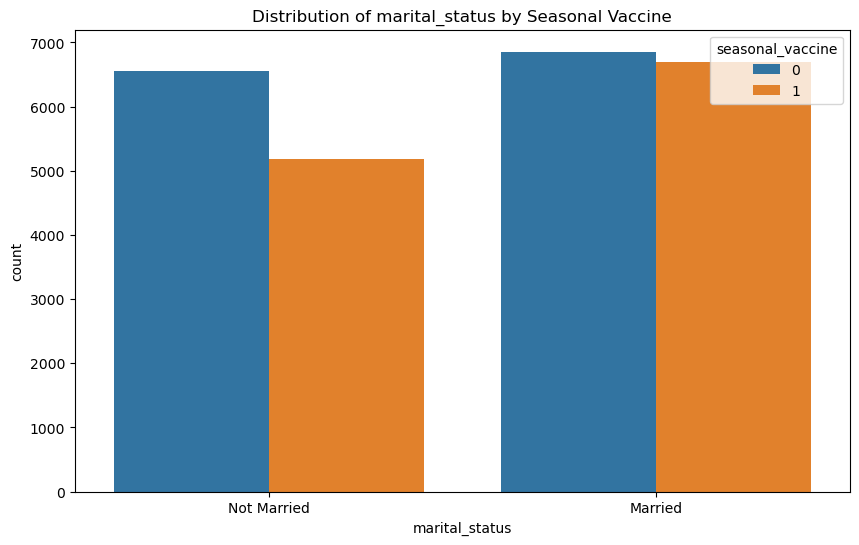

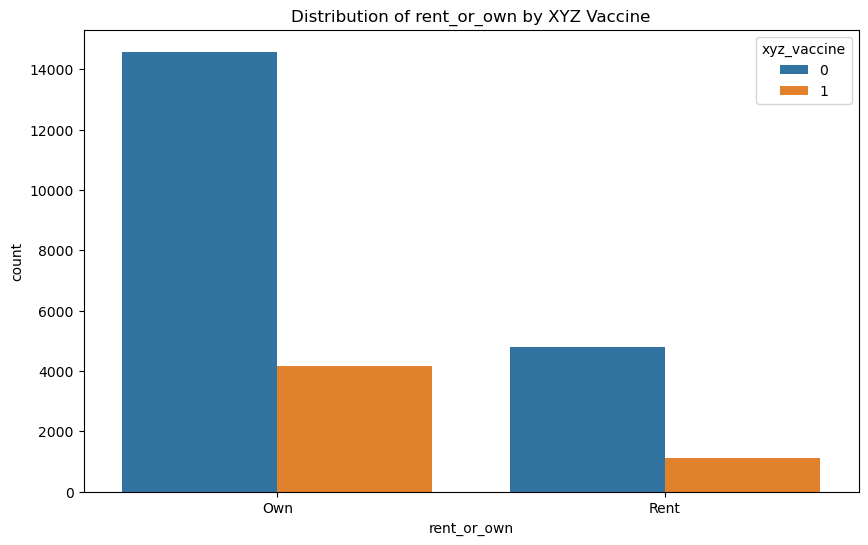

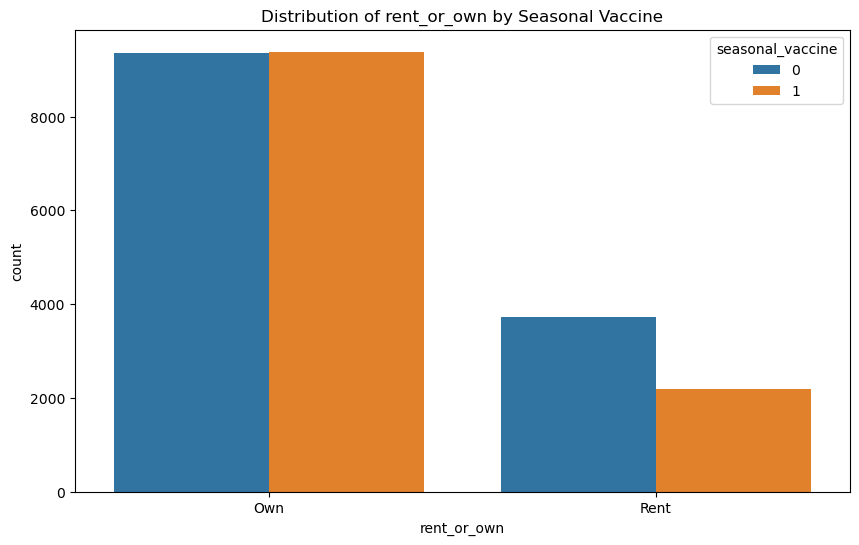

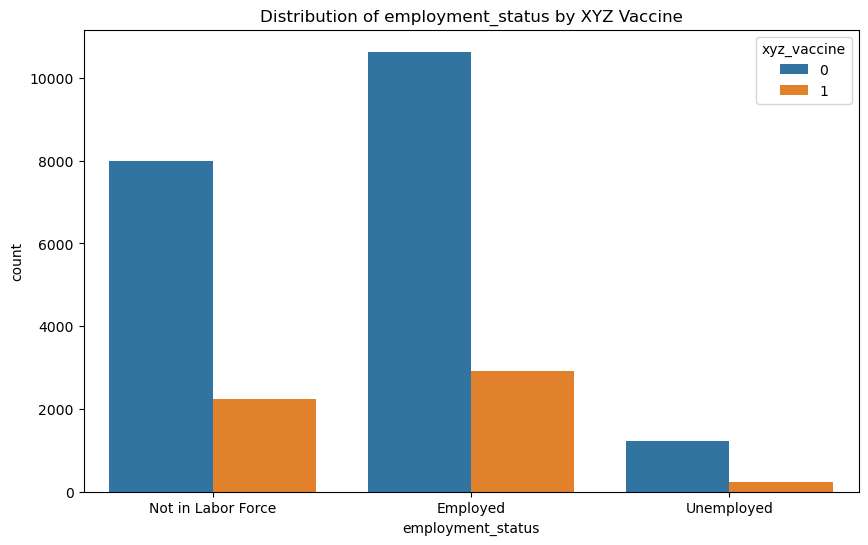

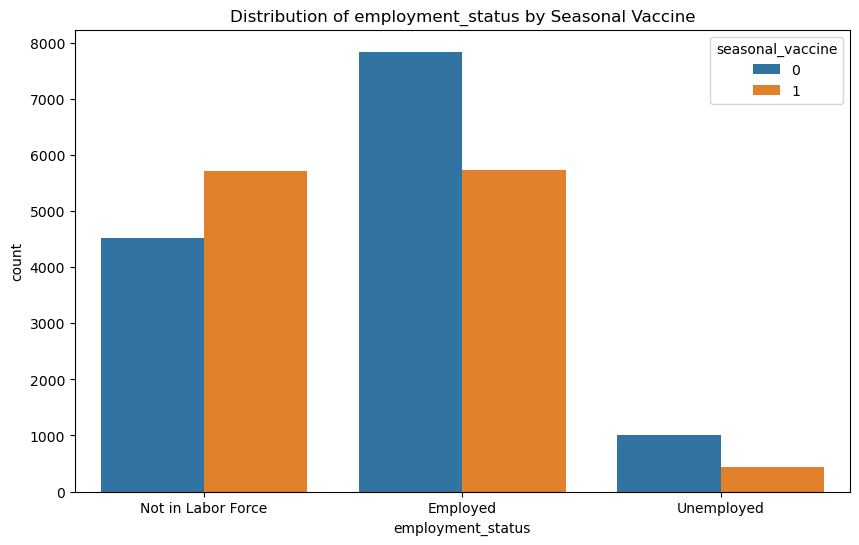

In [9]:
# Function to create count plots for categorical features
def plot_categorical_feature(feature):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_data, x=feature, hue='xyz_vaccine')
    plt.title(f'Distribution of {feature} by XYZ Vaccine')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_data, x=feature, hue='seasonal_vaccine')
    plt.title(f'Distribution of {feature} by Seasonal Vaccine')
    plt.show()

# Plotting some categorical features
categorical_features = ['sex', 'age_group', 'education', 'race', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']
for feature in categorical_features:
    plot_categorical_feature(feature)

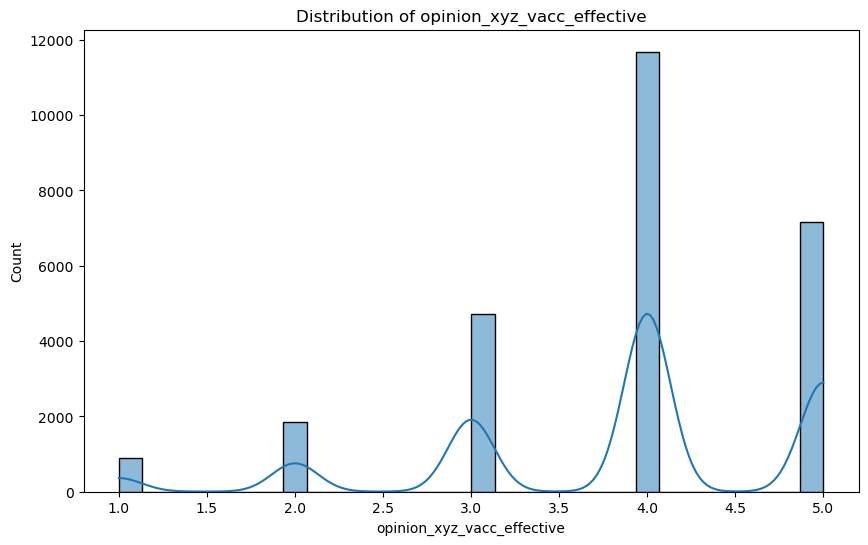

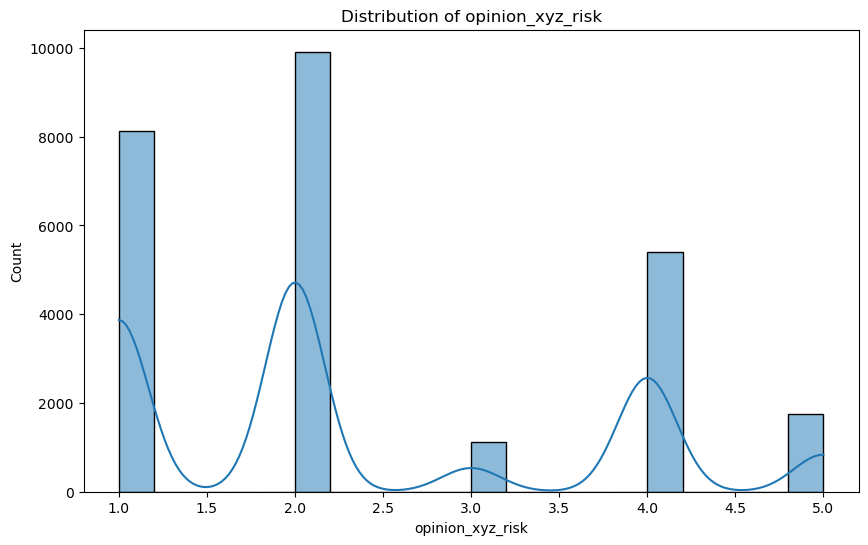

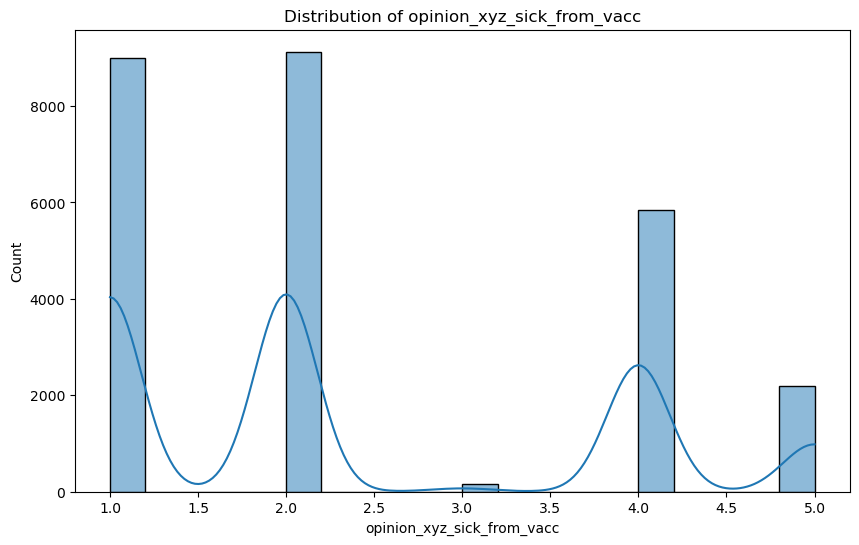

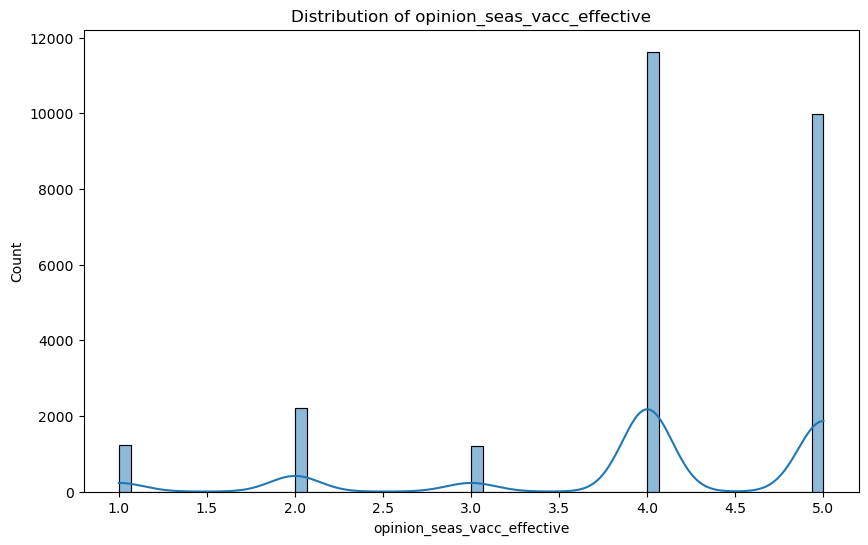

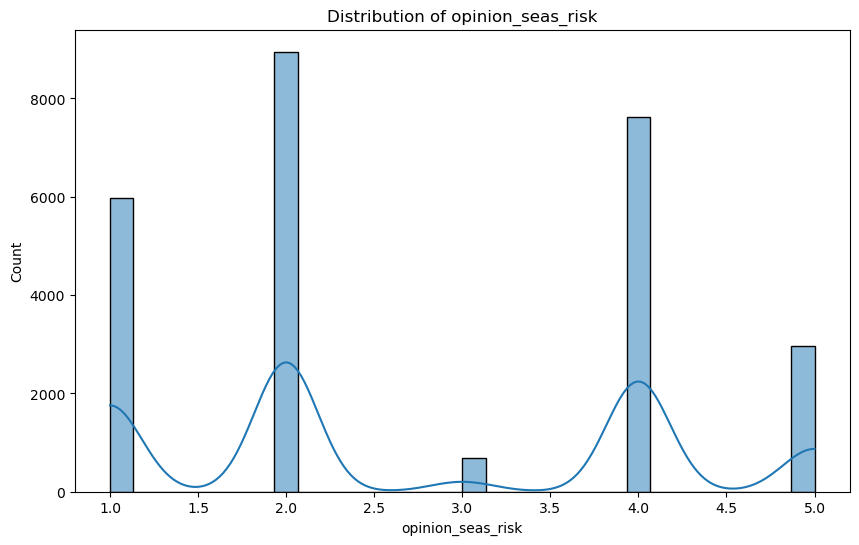

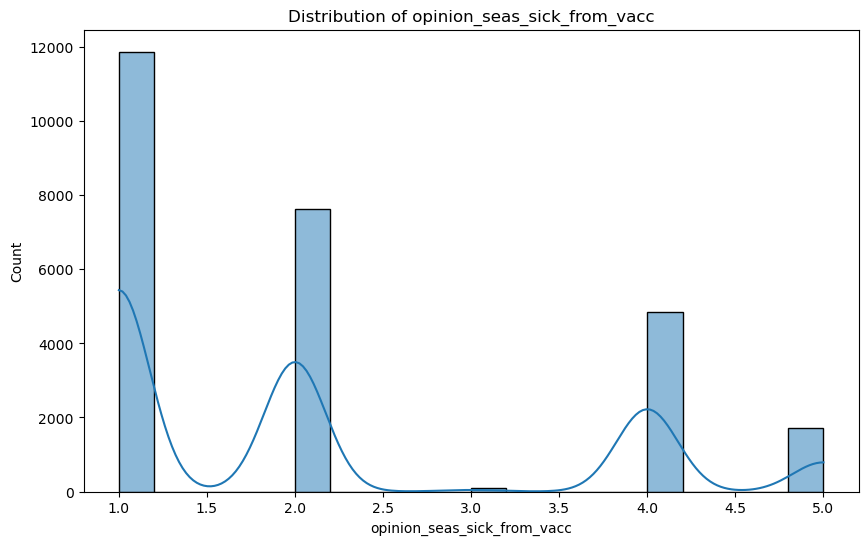

In [10]:
# Visualizing the distribution of numerical features
numerical_features = ['opinion_xyz_vacc_effective', 'opinion_xyz_risk', 'opinion_xyz_sick_from_vacc',
                      'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [11]:
# Select numerical and categorical columns
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop(['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'])
categorical_cols = train_data.select_dtypes(include=['object']).columns

# Pipeline

In [12]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [13]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [15]:
# Create and train the model using a pipeline
xyz_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [16]:
seasonal_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [17]:
# Split the data into training and testing sets
X = train_features.drop(columns=['respondent_id'])
y = train_labels[['xyz_vaccine', 'seasonal_vaccine']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_test.shape

((21365, 35), (5342, 35))

In [19]:
y_train.shape, y_test.shape

((21365, 2), (5342, 2))

In [20]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [21]:
# Grid search for xyz model
xyz_grid = GridSearchCV(xyz_pipeline, param_grid, cv=5, scoring='roc_auc')
xyz_grid.fit(X_train, y_train['xyz_vaccine'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatheri...
                                                                         Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

In [22]:
# Grid search for seasonal model
seasonal_grid = GridSearchCV(seasonal_pipeline, param_grid, cv=5, scoring='roc_auc')
seasonal_grid.fit(X_train, y_train['seasonal_vaccine'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatheri...
                                                                         Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

In [23]:
# Make predictions on the validation set
xyz_val_preds = xyz_grid.predict_proba(X_test)[:, 1]
seasonal_val_preds = seasonal_grid.predict_proba(X_test)[:, 1]

In [24]:
# Evaluate models
xyz_auc = roc_auc_score(y_test['xyz_vaccine'], xyz_val_preds)
seasonal_auc = roc_auc_score(y_test['seasonal_vaccine'], seasonal_val_preds)
print(f'XYZ Vaccine ROC AUC: {xyz_auc}')
print(f'Seasonal Vaccine ROC AUC: {seasonal_auc}')
print(f'Average ROC AUC: {(xyz_auc + seasonal_auc) / 2}')

XYZ Vaccine ROC AUC: 0.8353831026397398
Seasonal Vaccine ROC AUC: 0.856304706808973
Average ROC AUC: 0.8458439047243564


In [25]:
# Make predictions on the test set
X_val = test_features.drop(columns=['respondent_id'])
xyz_test_preds = xyz_grid.predict_proba(X_val)[:, 1]
seasonal_test_preds = seasonal_grid.predict_proba(X_val)[:, 1]

In [26]:
# Prepare submission file
submission = pd.DataFrame({
    'respondent_id': submission_format['respondent_id'],
    'xyz_vaccine': xyz_test_preds,
    'seasonal_vaccine': seasonal_test_preds
})

In [27]:
# Save submission
submission.to_csv('submission.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'submission.csv'